In [1]:
import json
from pprint import pprint
from termcolor import colored
from colored import fg, bg, attr
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# if using a Jupyter notebook, includue:
%matplotlib inline

data_file = "predictor_result/predictor_glove_only_enitites.jsonl"
id2name = "../data/id2name.json"

NUMBER_OF_SAMPELS = 100

color = bg('yellow_1') + fg('black')
reset = attr('reset')
blue = "blue"
green = "green"

print()

with open(id2name, 'r') as fp:
    id2name = json.load(fp)

def in_pos(indx, positions):
    for ent_pos in positions:
        if ent_pos[0] <= indx < ent_pos[1]:
            return True

    return False

In [34]:
#load glove vectors
glove = '/Users/ofersabo/Downloads/glove.840B.300d.txt'
tokens = set()
with open(glove, 'r') as fp:
    for l in fp:
        line = l.split(' ')
        tokens.update([line[0].lower()])


In [35]:
def change_word_by_entity(entity_str, this_sentence,i,color):
        if list(map(lambda x: x.lower(), this_sentence[i:i + len(entity_str.split(" "))])) == entity_str.split():
            this_sentence = this_sentence[:i] + [colored(w, color, attrs=['bold']) for w in entity_str.split()] + \
                            this_sentence[i + len(entity_str.split(" ")):]
        return this_sentence


In [36]:
preffix = ""
def _show_sentence(head,tail,this_sentence,relation,correct_relation = None, is_prediction = False,prob : str = "",score: str = ""):
    print(preffix + "head:", colored(head, 'blue', attrs=['bold']), "  ,  ", "tail", colored(tail, 'green', attrs=['bold']))          
    this_sentence = this_sentence.split()
    for i, word in enumerate(this_sentence):
            if word.lower() == head.split()[0]:
                this_sentence = change_word_by_entity(head, this_sentence,i,blue)
            if word.lower() == tail.split()[0]:
                this_sentence = change_word_by_entity(tail, this_sentence,i,green)
    color = 'yellow' if correct_relation is None or relation == correct_relation else 'grey'
    if is_prediction: color = "red"
    if len(prob) > 0:
        print(preffix + colored(relation, color,attrs=['bold']) + "\t", " ".join(this_sentence) +" " + colored(prob, "magenta",attrs=['bold'])+"; "+ 
              colored(score, "magenta",attrs=['bold']))
    else:
        print(preffix + colored(relation, color,attrs=['bold']) + "\t", " ".join(this_sentence))

In [37]:
def show_set(data,to_print = True):
    in_glove_vocb = []
    correct_relation = data['correct_relation']
    prediction = data["prediction"]
    query = data['query']
    head = data['query_head']
    tail = data['query_tail']
    probability = data['probability'].replace("'","")[1:-1].split(",")
    scores = data['scores']
    if to_print: 
        _show_sentence(head,tail,query,correct_relation)
        print()

    for k in range(5):
        this_sentence = data["sentence_" +str(k)]
        head = data['sentence_'+str(k)+'_head']
        head_in_glove = head in tokens
        tail = data['sentence_'+str(k)+'_tail']
        tail_in_glove = tail in tokens
        in_glove_vocb.append((head_in_glove,tail_in_glove))
        relation = data['sentence_'+str(k)+'_relation']
        if to_print:
            _show_sentence(head,tail,this_sentence,relation,correct_relation,  k == int(prediction),probability[k],
                           "{:.2f}".format(scores[k]))
    if to_print: print()

    return correct_relation,in_glove_vocb
        

In [38]:
def sum_positive_and_negative(in_glove,the_counter):
    for h,t in in_glove:
        the_counter.update([t,h]) 
        

In [40]:
total_wrong = 0
total_correct = 0
result_per_type = {}
negative_counter = Counter()
positive_counter = Counter()
correct_scroes = []
wrong_scores = []
wrong_prediction_which_rel = {}
with open(data_file) as f:
    for ex_index,line in enumerate(f,1):
        data = json.loads(line)
        scores = data['scores']
        pred_rel = data['sentence_' + data["prediction"] +'_relation']
        pred_score = scores[int(data["prediction"])]
        the_gold_rel = data['correct_relation']
        if data['answer'] == "wrong":
            total_wrong +=1
#             print("wrong example number: ",total_wrong,  "example number: ", ex_index)
            correct_relation,in_glove_vocb = show_set(data,False)
            sum_positive_and_negative(in_glove_vocb,negative_counter)

            wrong_prediction_which_rel[the_gold_rel] = wrong_prediction_which_rel.get(the_gold_rel,Counter())
            wrong_prediction_which_rel[the_gold_rel].update([pred_rel])
            wrong_scores.append(pred_score)
            result_per_type[the_gold_rel] = result_per_type.get(the_gold_rel,[[],[]])
            result_per_type[the_gold_rel][0].append(data)
            
            
            
        else:
            result_per_type[the_gold_rel] = result_per_type.get(the_gold_rel,[[],[]])
            result_per_type[the_gold_rel][1].append(data)
            correct_scroes.append(pred_score)
            correct_relation,in_glove_vocb = show_set(data,False)
            sum_positive_and_negative(in_glove_vocb,positive_counter)
            total_correct +=1





In [41]:
negative_counter[True] / (negative_counter[False] + negative_counter[True]) 

0.3128746104051786

In [42]:
positive_counter[True] / (positive_counter[False] + positive_counter[True]) 

0.311219763252702

In [32]:
'Euphemia' in tokens

True

In [8]:
print(total_wrong/(total_correct+total_wrong))
print((total_correct+total_wrong))

0.4171
10000


In [33]:
for k,v in result_per_type.items():
    print("acc for ", k)
#     print("total from this category:",(len(v[0])+len(v[1])))
    print(len(v[1])/ (len(v[0])+len(v[1]) ))

acc for  member of
0.34039087947882735
acc for  crosses
0.8102409638554217
acc for  part of
0.3727422003284072
acc for  mother
0.5906821963394343
acc for  child
0.5913461538461539
acc for  main subject
0.464041095890411
acc for  military rank
0.6724137931034483
acc for  located in or next to body of water
0.6903323262839879
acc for  voice type
0.5652173913043478
acc for  follows
0.5640625
acc for  original language of film or TV show
0.6368159203980099
acc for  position played on team / speciality
0.5593495934959349
acc for  spouse
0.6823899371069182
acc for  competition class
0.664167916041979
acc for  constellation
0.7261345852895149
acc for  sport
0.33104631217838765


In [18]:
# check similarity between relations on train and dev
wrong_scores = np.array(wrong_scores)
correct_scroes = np.array(correct_scroes)


In [19]:
wrong_scores.mean()


37.723232936591494

In [20]:
correct_scroes.mean()


42.823280920602684

In [21]:
wrong_scores.std()


3.2567313720316005

In [22]:
correct_scroes.std()


4.907898756197537

In [23]:
np.max(wrong_scores)


61.34579086303711

(array([ 40., 369., 784., 697., 202.,  41.,   3.,   0.,   1.,   1.]),
 array([28.21909904, 31.53176823, 34.84443741, 38.15710659, 41.46977577,
        44.78244495, 48.09511414, 51.40778332, 54.7204525 , 58.03312168,
        61.34579086]),
 <a list of 10 Patch objects>)

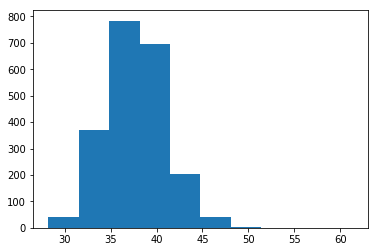

In [24]:
plt.hist(wrong_scores)



(array([0.00175097, 0.01659774, 0.05147125, 0.07368669, 0.07857482,
        0.04081951, 0.01747323, 0.00339251, 0.00280885, 0.00021887]),
 array([28.74953842, 32.23635635, 35.72317429, 39.20999222, 42.69681015,
        46.18362808, 49.67044601, 53.15726395, 56.64408188, 60.13089981,
        63.61771774]),
 <a list of 10 Patch objects>)

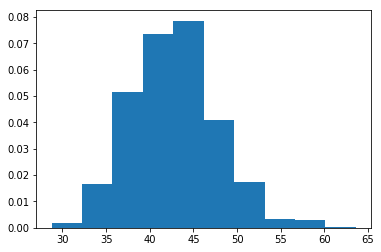

In [25]:
plt.hist(correct_scroes,density=True)

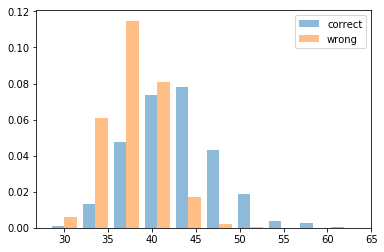

In [26]:
bins = [35,45,55,60,65,70]
plt.hist([correct_scroes,wrong_scores], 10, alpha=0.5, label=['correct','wrong'],density=True)
# plt.hist(wrong_scores, 10, alpha=0.5, label='wrong')
plt.legend(loc='upper right')
# plt.show()

In [28]:
# check unigrams intersection with other relations, both on tokens and entities
# on train as well
for d in result_per_type['voice type'][1]:
    show_set(d)
    print()
    

head: josef metternich   ,   tail baritone
voice type	 Thereupon followed a move to Feldafing on Lake Starnberg , where Dryden spent the better part of two years working with the German baritone josef metternich .

head: virginia macwatters   ,   tail soprano
voice type	 virginia macwatters ( June 19 , 1912 – November 5 , 2005 ) was an American coloratura soprano . 1.00; 45.53
head: lady shi   ,   tail yang xingmi
spouse	 His mother was yang xingmi 's concubine lady shi , who was also the mother of his older brother Yang Wo .  0.00; 28.45
head: nutrition books   ,   tail vegan
main subject	 A vegan , Silverstone has endorsed PETA activities and has published two nutrition books .  0.00; 29.99
head: gentleman   ,   tail gangnam style
follows	 The music video was shot in a style to Psy 's singles " gangnam style " and " gentleman " .  0.00; 30.11
head: malcolm orme little   ,   tail brigadier-general
military rank	 Brigadier - General malcolm orme little , ( 29 November 1857 – 1 February

mother	 Initially , Northern Zhou continued to detain Chen Xu 's wife liu jingyan and son chen shubao , but after further negotiations , Northern Zhou released them as well .  0.00; 31.05


head: badri maisuradze   ,   tail tenor
voice type	 badri maisuradze ( ) ( born on November 13 , 1966 ) is a Georgian tenor opera singer , a leading dramatic tenor of the Bolshoi Theatre in Moscow , Russia .

head: constance   ,   tail alice
mother	 In the winter of 1135–36 , Ralph supported the regency of constance 's mother , alice . 0.00; 29.50
head: saving private ryan   ,   tail world war ii
main subject	 In the film " saving private ryan " , cinematographer Janusz Kamiński used such a shutter adjustment to give his film the look of world war ii newsreel photography .  0.00; 26.75
head: vijay kaaviya neram   ,   tail tamil dubbed
original language of film or TV show	 vijay kaaviya neram ( ) is a tamil dubbed soap opera that aired on STAR Vijay .  0.00; 28.66
head: george zervanos   ,   tail ten


head: valdemar christian   ,   tail kirstine munk
mother	 The king ’s plans for his new castle were that the house should become the home for his son valdemar christian , who was born to him by kirstine munk . 0.00; 30.54
head: 2015   ,   tail 2011
follows	 Colombia ( 2000 , 2011 , 2015 ) are the current cup holders .  0.00; 28.05
head: željko lučić   ,   tail baritone
voice type	 željko lučić ( born 24 February 1968 ) is a Serbian operatic baritone who has had an active international career since 1993 .  1.00; 45.06
head: césar taborda   ,   tail goalkeeper
position played on team / speciality	 césar taborda ( born January 23 , 1984 ) is an Argentine football goalkeeper who plays for Central Córdoba de Santiago del Estero .  0.00; 36.11
head: fritzie zivic   ,   tail welterweight
competition class	 He then fought a memorable non - title fight against welterweight champion fritzie zivic on November 15 .  0.00; 36.46


head: sharon coste   ,   tail soprano
voice type	 sharon coste ( bo

head: trude eipperle   ,   tail soprano
voice type	 trude eipperle ( 27 January 1908 – 18 October 1997 ) was a German operatic soprano .  1.00; 44.44
head: denys cochin   ,   tail augustin cochin
child	 He was the father of the Catholic politician denys cochin and the grandfather of the historian augustin cochin .  0.00; 27.09
head: agni ips   ,   tail kannada
original language of film or TV show	 In kannada films , her notable supporting performances included her roles in " Anuraga Sangama " ( 1995 ) and " agni ips " ( 1997 ) .  0.00; 27.57
head: aşkkolik   ,   tail deli oğlan
follows	 These included " My Body " , " Do n't ask " , " deli oğlan " and " aşkkolik " , to promote the album and its lead for Turkey , deli oğlan .  0.00; 24.13


head: frédérique vézina   ,   tail soprano
voice type	 frédérique vézina ( born ) is a Canadian operatic soprano .

head: quark   ,   tail hadron
part of	 It takes place when a quark of one hadron and an antiquark of another hadron annihilate , creati

constellation	 ngc 448 is a lenticular galaxy of type S0 ^ - ( edge - on ) located approximately away in the constellation cetus . 0.00; 26.26
head: dame joan sutherland   ,   tail mezzos
voice type	 Among the sopranos and mezzos are Dame Janet Baker , Victoria de los Ángeles , Natalie Dessay , Renée Fleming , Angela Gheorghiu and dame joan sutherland .  1.00; 39.67
head: bella   ,   tail edward
spouse	 In " Breaking Dawn " her role is limited ; her father reads bella and edward 's vows at their wedding , and she catches bella 's bouquet .  0.00; 29.13
head: rc narbonne   ,   tail rugby union
sport	 Narbonne is home to the rugby union team rc narbonne founded in 1907 .  0.00; 30.74
head: frank islacker   ,   tail mandy islacker
child	 He was the father of frank islacker and the grandfather of mandy islacker .  0.00; 30.64


head: q lazzarus   ,   tail contralto
voice type	 q lazzarus is known for having a deep , husky contralto voice .

head: bronze age   ,   tail chalcolithic
follows	

head: rhaetian   ,   tail late triassic
part of	 The Blue Lias , also referred to as the Lower Lias , dates back to the late triassic - Early Jurassic boundary , thus includes the rhaetian , Hettangian , and lower Sinemurian stages . 0.00; 29.28
head: murong wei   ,   tail empress dowager kezuhun
mother	 She was the daughter of Kezuhun Yi ( 可足渾翼 ) , the cousin of murong wei 's mother empress dowager kezuhun .  0.00; 31.13
head: hammersmith bridge   ,   tail river thames
crosses	 The Harrods Furniture Depository buildings flank the South bank of the river thames near hammersmith bridge in Barnes , London SW13 .  0.00; 29.36
head: glaphyra   ,   tail alexander of judea
spouse	 In 18/17 BC , his daughter glaphyra married prince alexander of judea in an arranged ceremony .  0.00; 29.13
head: sylvester groth   ,   tail tenor
voice type	 sylvester groth ( born 31 March 1958 ) is a German film actor and tenor .  1.00; 45.04


head: elisabeth schärtel   ,   tail mezzo-soprano
voice type	 elisa

head: nikolai ogarkov   ,   tail marshal of the soviet union
military rank	 The museum is named after nikolai ogarkov , marshal of the soviet union , who was born in Molokovo , and presents expositions about Ogarkov .  0.00; 31.65
head: magnus v of norway   ,   tail kristin sigurdsdatter
mother	 She had a daughter , kristin sigurdsdatter , mother of king magnus v of norway .  0.00; 28.21


head: kathleen ferrier   ,   tail contralto
voice type	 The contralto , kathleen ferrier ( 1912–1953 ) was born in the village .

head: maricris garcia   ,   tail mezzo-soprano
voice type	 They have a blending of vocal styles ; Jonalyn Viray being the soprano , maricris garcia taking the place of the mezzo - soprano , and Aicelle Santos as the alto . 1.00; 48.07
head: bjørnsletta   ,   tail oslo metro
part of	 bjørnsletta was a station on the Kolsås Line ( line 6 ) of the oslo metro in Norway .  0.00; 27.34
head: clinton woods   ,   tail light heavyweight
competition class	 He has also trained light 

head: essi wuorela   ,   tail soprano
voice type	 essi wuorela is a Finnish soprano . 1.00; 45.70
head: inspector clouseau   ,   tail a shot in the dark
follows	 Various recordings of the composition appeared in the opening credits of all " The Pink Panther " films except " a shot in the dark " and " inspector clouseau " .  0.00; 30.61
head: johnnie johnson   ,   tail air vice-marshal
military rank	 On 24 June 1988 a plaque was unveiled at 183 Mill Road , Wellingborough by top scoring World War 2 British fighter pilot Air Vice - Marshal johnnie johnson .  0.00; 34.52
head: ngc 450   ,   tail cetus
constellation	 ngc 450 is a spiral galaxy located in the constellation cetus .  0.00; 24.33
head: yamagola   ,   tail telugu
original language of film or TV show	 The film is remake of telugu blockbuster Movie " yamagola " ( 1977 ) , starring N.T.Rama Rao , Jayapradha in pivotal roles .  0.00; 29.25


head: perry askam   ,   tail baritone
voice type	 perry askam ( 1898–1961 ) was a 20th - cen

voice type	 dorothy sarnoff ( May 25 , 1914 – December 20 , 2008 ) was an American operatic soprano , musical theatre actress , and self - help guru .

head: otakar kraus   ,   tail baritone
voice type	 otakar kraus ( 10 December 1909 — 28 July 1980 ) was a Czech ( later British ) , operatic baritone and teacher . 1.00; 45.72
head: charles v   ,   tail margaret of parma
child	 In 1582 the town was acquired by margaret of parma , daughter of Emperor charles v and Duchess of Parma .  0.00; 30.27
head: second season   ,   tail dexter
part of	 The Dark Defender character also lent its name to a series of highly stylized " dexter " webisodes , recapping dexter 's victims of the second season .  0.00; 29.28
head: the sullivans   ,   tail world war ii
main subject	 Greater success came with " the sullivans " ( 1976–82 ) , a critically acclaimed and highly popular world war ii family serial co - starring Lorraine Bayly and former Matlock lead Paul Cronin .  0.00; 27.61
head: marc andreu   ,   

head: julian gayarre   ,   tail tenor
voice type	 This was followed by a highly successful concert tour throughout Germany , Italy , Argentina , and Brazil with tenor julian gayarre .

head: juan carlos echeverry bernal   ,   tail tenor
voice type	 juan carlos echeverry bernal is a Colombian operatic tenor . 1.00; 44.37
head: lord gort   ,   tail field marshal
military rank	 In a telegram to field marshal lord gort on 27 May , only one day before the Belgian capitulation , he wrote , " We are asking them to sacrifice themselves for us .  0.00; 34.16
head: keith rivers   ,   tail linebacker
position played on team / speciality	 During a game on October 19 , 2008 , Ward put a vicious downfield blindside block on rookie Cincinnati Bengals linebacker keith rivers .  0.00; 33.86
head: pravarasena   ,   tail prabhavatigupta
mother	 His father 's early death led to prabhavatigupta ruling as regent for an extended period of time as their sons Divakarasena , Damodarasena , and pravarasena were 

In [46]:
negative_counter

Counter({'large intestine': 9,
         'rectum': 7,
         'hermaphroditus': 7,
         'aphrodite': 15,
         'perseus': 27,
         'ugc 2503': 6,
         'appomattox river': 3,
         'high bridge': 6,
         'malthace': 8,
         'herod antipas': 4,
         'supervisory board': 3,
         'friedrich merz': 3,
         'contralto': 47,
         'kathleen ferrier': 1,
         'spanish civil war': 7,
         'spain in flames': 2,
         'franz joseph i': 1,
         'elisabeth': 4,
         '1984 summer olympics': 2,
         'soling class': 2,
         'brisbane river': 17,
         'albert bridge': 6,
         'afeni shakur': 4,
         'tupac': 4,
         'encore': 6,
         'like toy soldiers': 6,
         'soprano': 479,
         'mattiwilda dobbs': 3,
         'ivan sratsimir': 3,
         'ivan alexander': 3,
         'virginia macwatters': 3,
         'yang xingmi': 2,
         'lady shi': 2,
         'vegan': 5,
         'nutrition books': 5,
        

In [19]:
def show_statson_all_relation(correct = 0):
    pred_acc = []
    scores_result = []
    std_result = [] 
    for k,v in result_per_type.items():
        scores_category = np.array(list(map(lambda x: x['scores'][int(x['prediction'])],v[correct])))
        pred_acc.append(len(v[1])/(len(v[0])+len(v[1]))*100)
        scores_result.append(scores_category.mean())
        std_result.append(scores_category.std())
        print(f"{k}:\t {scores_category.mean():.2f} +- {scores_category.std():.2f} ; {len(v[1])/(len(v[0])+len(v[1]))*100:.2f}%")
    #     print( k ,scores_category.mean(), "+-",scores_category.std(), " Acc is:", len(v[1])/(len(v[0])+len(v[1])))
    pred_acc = np.array(pred_acc)
    scores_result = np.array(scores_result)
    std_result = np.array(std_result)
#     X = np.stack((pred_acc,scores_result),axis=0)
#     print(np.cov(X))
#     print(np.corrcoef(np.stack((pred_acc,scores_result),axis=0)))
    return pred_acc,scores_result,std_result

In [20]:
pred_acc,scores_result_correct,std_result_correct = show_statson_all_relation(1)

member of:	 36.14 +- 1.68 ; 55.37%
crosses:	 43.08 +- 3.11 ; 96.39%
part of:	 36.14 +- 2.77 ; 38.42%
mother:	 37.05 +- 1.69 ; 58.07%
child:	 37.46 +- 1.94 ; 64.90%
main subject:	 37.41 +- 3.38 ; 59.93%
military rank:	 43.63 +- 2.77 ; 97.18%
located in or next to body of water:	 39.48 +- 2.33 ; 83.53%
voice type:	 46.39 +- 2.53 ; 99.84%
follows:	 37.93 +- 2.86 ; 67.66%
original language of film or TV show:	 38.52 +- 2.52 ; 93.70%
position played on team / speciality:	 43.10 +- 1.85 ; 94.31%
spouse:	 37.41 +- 1.84 ; 66.51%
competition class:	 47.32 +- 3.38 ; 97.15%
constellation:	 38.43 +- 2.10 ; 81.38%
sport:	 40.17 +- 2.70 ; 83.70%


In [21]:
from scipy.stats import pearsonr

In [22]:
pearsonr(pred_acc,scores_result_correct)

(0.8401013488677861, 4.643738699879324e-05)

In [23]:
pred_acc,scores_result_wrong,std_result_wrong = show_statson_all_relation(0)

member of:	 35.37 +- 1.41 ; 55.37%
crosses:	 37.63 +- 2.05 ; 96.39%
part of:	 35.69 +- 1.92 ; 38.42%
mother:	 36.85 +- 1.73 ; 58.07%
child:	 36.86 +- 1.97 ; 64.90%
main subject:	 35.58 +- 1.99 ; 59.93%
military rank:	 38.63 +- 2.37 ; 97.18%
located in or next to body of water:	 39.24 +- 2.85 ; 83.53%
voice type:	 40.22 +- 0.00 ; 99.84%
follows:	 35.69 +- 1.30 ; 67.66%
original language of film or TV show:	 36.24 +- 1.75 ; 93.70%
position played on team / speciality:	 39.77 +- 1.57 ; 94.31%
spouse:	 37.04 +- 1.98 ; 66.51%
competition class:	 37.86 +- 1.91 ; 97.15%
constellation:	 36.41 +- 1.43 ; 81.38%
sport:	 38.39 +- 2.32 ; 83.70%


In [24]:
pearsonr(pred_acc,scores_result_wrong)

(0.7225703289880748, 0.0015676944995754484)

In [25]:
scores_result_correct - scores_result_wrong

array([0.7678779 , 5.45754876, 0.4588019 , 0.20565624, 0.59657201,
       1.82349931, 5.00169318, 0.23537707, 6.17134615, 2.23889973,
       2.28013809, 3.33642598, 0.36385862, 9.45989966, 2.01646761,
       1.7853166 ])

In [26]:
print(pred_acc)

[55.37459283 96.38554217 38.42364532 58.06988353 64.90384615 59.93150685
 97.17868339 83.5347432  99.8389694  67.65625    93.69817579 94.30894309
 66.50943396 97.15142429 81.3771518  83.70497427]


In [30]:
for v in result_per_type["part of"][1]:
    show_set(v)
    print()

part of	 Moffat also brought back the character of River Song from his fourth series episodes " Silence in the Library " and " forest of the dead " .

part of	 Ulcerative colitis and familial adenomatous polyposis are the two main health conditions that lead to removal of the entire colon ( large intestine ) and rectum , which leads to the need for an ileostomy . 0.74; 35.99
child	 In the mythological tradition , hermaphroditus was a beautiful youth who was the son of Hermes ( Roman Mercury ) and aphrodite ( Venus).Ovid , " Metamorphoses " 4.287–88 .  0.08; 33.73
constellation	 NGC 1169 ( ugc 2503 ) is an intermediate barred spiral galaxy in the constellation of perseus .  0.10; 33.96
crosses	 Following a more circuitous route through Farmville in response to financial incentives from the community , the railroad constructed the famous 21 span high bridge across the appomattox river valley about east of Farmville .  0.08; 33.80
mother	 He was the son of Herod the Great and malthace the

voice type	 In 1953 , at the age of seven , Nielsen met the Austrian soprano hilde güden while she was on tour in Iowa .  0.00; 28.37
part of	 " The Seemingly Never - Ending Story " is the 13th episode of " The Simpsons " ' 17th season .  0.99; 38.82
constellation	 ngc 447 is a spiral galaxy of type ( R)SB(rs)0/a located in the constellation pisces .  0.01; 33.58


part of	 ' sad angel ' is a song by Fleetwood Mac , written by guitarist and vocalist Lindsey Buckingham , from their EP extended play , released in 2013 .

part of	 On September 17 , 2013 , he released the first single from his second studio album " my own lane " , entitled " show me " featuring Chris Brown and produced by DJ Mustard . 0.88; 34.93
follows	 The mitsubishi toppo is a light recreational vehicle ( RV ) produced by Mitsubishi Motors from 1990 until 2004 , derived from their minica kei car .  0.05; 32.15
spouse	 After his coronation , ivan asen ii arranged a wedding with anna maria , daughter of the Hungarian kin

In [414]:
for k,v in wrong_prediction_which_rel.items():
    print (k)
    print(v.most_common())
    print()

crosses
[('located in or next to body of water', 23), ('part of', 2), ('constellation', 1)]

main subject
[('follows', 23), ('part of', 22), ('sport', 21), ('member of', 16), ('constellation', 12), ('original language of film or TV show', 6), ('voice type', 6), ('military rank', 5), ('located in or next to body of water', 5), ('spouse', 5), ('mother', 4), ('crosses', 4), ('competition class', 3), ('child', 2), ('position played on team / speciality', 1)]

part of
[('constellation', 68), ('located in or next to body of water', 55), ('main subject', 46), ('crosses', 43), ('follows', 33), ('member of', 31), ('sport', 14), ('competition class', 9), ('position played on team / speciality', 8), ('voice type', 7), ('original language of film or TV show', 6), ('military rank', 6), ('mother', 3), ('child', 3), ('spouse', 1)]

member of
[('part of', 27), ('voice type', 24), ('constellation', 22), ('military rank', 22), ('competition class', 14), ('main subject', 12), ('sport', 12), ('position pl

In [ ]:
# check agremment with the model prediction 
# try to come up with b=new baselines to show that data is no good
# Elmo should do worse?
# only entity type is helpful?